<a href="https://colab.research.google.com/github/CanopySimulations/canopy-python-examples/blob/master/fitting_aero_data_to_polynomial_and_rbf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Upgrade Runtime
This cell ensures the runtime supports `asyncio` async/await, and is needed on Google Colab. If the runtime is upgraded, you will be prompted to restart it, which you should do before continuing execution.

In [0]:
!pip install "ipython>=7"

# Set Up Environment

### Import required libraries

In [0]:
!pip install -q 'canopy==8.9'

In [0]:
import canopy
import logging
import numpy as np
from numpy.matlib import repmat
import matplotlib.pyplot as plt
import pandas as pd
import json
from typing import Sequence, Optional, NamedTuple, Any

logging.basicConfig(level=logging.INFO)
np.set_printoptions(suppress=True)

### Authenticate

In [0]:
authentication_data = canopy.prompt_for_authentication()

def create_session():
    return canopy.Session(authentication_data)

# Set Up Example

Later in this example we render the aero component we have generated as JSON. The `np.ndarray` type is not JSON serializable by default, so this simple encoder converts `np.ndarray` to a Python array during serialization.


In [0]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

# Example: Fitting Aero Data to a Polynomial and RBF.

Using a CSV of aero data containing the columns `hRidef`, `hRideR`, `aRollAbs`, `CLiftBodyF`, `CLiftBodyR` and `CDragBody` we will fit the data to a polynomial and then fit the residuals of the polynomial to an RBF.

We will then generate a Canopy aero component from the data and save a new car to the Canopy platform containing the new aero data.

## Create Helper Functions

This function returns a random set indices, given a data length and maximum number of positions.

In [0]:
def create_basis_position_indices(data_length: int, max_positions: int) -> Sequence[int]:
    n = min(max_positions, data_length)
    random_index_permutation = np.random.permutation(data_length)
    basis_position_indices = random_index_permutation[0:n]
    return basis_position_indices

This function will do the fitting, and return a `FittedAeroData` class containing the information we need to construct the car component.


In [0]:
class FittedAeroData(NamedTuple):
    polynomial_residuals: pd.DataFrame
    polynomial_rbf_residuals: pd.DataFrame
    polynomial_coefficients: np.ndarray
    rbf_basis_weights: np.ndarray
    input_offsets: np.ndarray 
    input_scales: np.ndarray
    input_length_scales: np.ndarray
    input_basis_positions: np.ndarray

# input_basis_position_indices defaults to a random 150 indices.
# input_length_scales defaults to all ones.
def fit_aero_data(
        data: pd.DataFrame,
        input_names: Sequence[str],
        output_names: Sequence[str],
        input_basis_position_indices: Optional[Sequence[int]] = None,
        input_length_scales: Optional[Sequence[float]] = None) -> FittedAeroData:

    data_length = len(data)
    input_count = len(input_names)
    inputs = data[input_names].to_numpy()
    outputs = data[output_names].to_numpy()
    
    # Set default parameter values if not provided.
    if input_basis_position_indices is None:
        input_basis_position_indices = create_basis_position_indices(data_length, 150)

    if input_length_scales is None:
        input_length_scales = np.ones((input_count,1))
    else:
        input_length_scales = np.reshape(input_length_scales, (input_count, 1))

    # Scale all the input data so it ranges between +/- 1.
    inputs_max = inputs.max(0)
    inputs_min = inputs.min(0)

    input_offsets = -0.5 * (inputs_max + inputs_min)
    input_scales = 0.5 * (inputs_max - inputs_min)

    input_scaled = inputs + repmat(input_offsets, data_length, 1)
    input_scaled = input_scaled / repmat(input_scales, data_length, 1)

    # Now fit a simple polynomial. This consists of: 
    # 1. Cubic terms; 
    # 2. Quadratic terms. 
    # 3. All linear cross terms. 
    # 4. All linear terms. 
    # 5. A constant. 
    # It's not meant to be a perfect fit, just a passable one.
    polynomial = np.concatenate((
        inputs**3,
        inputs**2),
        axis=1)
    
    for i in range(0, input_count):
        for j in range(i+1, input_count):
            polynomial = np.concatenate((
                polynomial,
                (inputs[:,i] * inputs[:,j])[:, np.newaxis]),
                axis=1)

    polynomial = np.concatenate((
        polynomial,
        inputs, 
        (1+0*inputs[:, 0])[:, np.newaxis]),
        axis=1)
    
    polynomial_coefficients_result = np.linalg.lstsq(polynomial, outputs, rcond=None)
    polynomial_coefficients = polynomial_coefficients_result[0]

    polynomial_y = polynomial @ polynomial_coefficients

    # Compute the fit residuals: we're going to fit the RBF to these. 
    polynomial_residuals = outputs - polynomial_y

    input_basis_positions = input_scaled[input_basis_position_indices, :]
    input_basis_positions_length = len(input_basis_positions)

    # Compute the matrix of mahalanobis distances between all basis function
    # positions and all data points.
    mahalanobis_distances = np.zeros((data_length, input_basis_positions_length))
    for k in range(0,input_count):    
        mahalanobis_distances = \
            mahalanobis_distances + \
            input_length_scales[k] * (
                repmat(np.vstack(input_scaled[:,k]), 1, input_basis_positions_length) - 
                repmat(input_basis_positions[:, k].T, len(input_scaled), 1)
            )**2    

    # Take the exponential to yield the learning matrix.
    rbf = np.power(np.math.e, -mahalanobis_distances)

    # And compute the basis weights.
    rbf_basis_weights_result = np.linalg.lstsq(rbf, polynomial_residuals, rcond=None)
    rbf_basis_weights = rbf_basis_weights_result[0]

    # The final estimate is just the polynomial estimate + the rbf correction.
    polynomial_rbf_y = rbf @ rbf_basis_weights + polynomial_y

    polynomial_rbf_residuals = polynomial_rbf_y - outputs

    return FittedAeroData(
        polynomial_residuals,
        polynomial_rbf_residuals,
        polynomial_coefficients,
        rbf_basis_weights,
        input_offsets,
        input_scales,
        input_length_scales.flatten(),
        input_basis_positions)

This function will take the output of the `fit_aero_data` function and return a component we can put on a car.

In [0]:
def get_fit_as_component(
        fitted_aero_data: FittedAeroData,
        input_names: Sequence[str],
        output_names: Sequence[str]) -> Any:
    
    polynomial_coefficients = fitted_aero_data.polynomial_coefficients
    input_offsets = fitted_aero_data.input_offsets
    input_scales = fitted_aero_data.input_scales
    input_length_scales = fitted_aero_data.input_length_scales
    input_basis_positions = fitted_aero_data.input_basis_positions
    rbf_basis_weights = fitted_aero_data.rbf_basis_weights
    
    aero_freedoms = input_names
    polymaps = [f'Polynomial{output_name}Definition' for output_name in output_names]
    
    config = {}
    for i in range(0, len(polymaps)):
        polymap = polymaps[i]
        maps = []
        config[polymap] = maps
        
        k = 0
        for j in range(0, len(aero_freedoms)):
            maps.append({
                'expression': f'{aero_freedoms[j]} * {aero_freedoms[j]} * {aero_freedoms[j]}',
                'coefficient': polynomial_coefficients[k,i],
            })
            k += 1
        
        for j in range(0, len(aero_freedoms)):
            maps.append({
                'expression': f'{aero_freedoms[j]} * {aero_freedoms[j]}',
                'coefficient': polynomial_coefficients[k,i],
            })
            k += 1
            
        for m in range(0, len(aero_freedoms)):
            for j in range(m+1, len(aero_freedoms)):
                maps.append({
                    'expression': f'{aero_freedoms[m]} * {aero_freedoms[j]}',
                    'coefficient': polynomial_coefficients[k,i],
                })
                k += 1
                
        for j in range(0, len(aero_freedoms)):
            maps.append({
                'expression': aero_freedoms[j],
                'coefficient': polynomial_coefficients[k,i],
            })
            k += 1
            
        maps.append({
            'expression': 'Const',
            'coefficient': polynomial_coefficients[k,i],
        })
    
    radial_basis_function_aero_map = {
        'basisVariables': input_names,
        'xOffset': input_offsets,
        'xScaling': input_scales,
        'xLengthScales': input_length_scales,
        'xBasisPositions': input_basis_positions
    }
    
    for i, name in enumerate([f'{output_name}BasisWeights' for output_name in output_names]):
        radial_basis_function_aero_map[name] = rbf_basis_weights[:, i]
        
    config['radialBasisFunctionAeroMap'] = radial_basis_function_aero_map 
    
    return config

## Load data

We are loading the sample data from a CSV file in our `canopy-python-examples` GitHub repository.

In [56]:
sample_data = pd.read_csv('https://raw.githubusercontent.com/CanopySimulations/canopy-python-examples/master/data/canopy_f1_90_percent_barc_t9_t10_rh_scan_for_aeromap_rbf_sine_wave.csv')
sample_data

,hRideF,hRideR,aRollAbs,CLiftBodyF,CLiftBodyR,CDragBody
0,-0.002654,0.070993,3.328467e-03,1.906163,2.034354,0.819640
1,-0.009514,0.088048,1.487898e-02,2.128253,1.943626,0.878609
2,0.000537,0.090153,1.613331e-02,2.016960,2.160629,0.882672
3,0.004207,0.084581,1.629368e-02,1.915504,2.165675,0.859981
4,0.002992,0.082024,1.626428e-02,1.908604,2.123501,0.850876
...,...,...,...,...,...,...
247,-0.017477,0.083197,2.315976e-03,2.191508,1.732843,0.847463
248,-0.001652,0.099344,2.417001e-03,2.156371,2.246043,0.900522
249,0.009221,0.102049,1.128490e-02,1.998724,2.353952,0.921972
250,0.011404,0.097143,1.001568e-02,1.957492,2.357822,0.905300


## Perform the fit

In [0]:
input_names = ['hRideF', 'hRideR', 'aRollAbs']
output_names = ['CLiftBodyF', 'CLiftBodyR', 'CDragBody']

# We'll override the length scales to something more appropriate for this data.
input_length_scales = [10., 10., 10.]

fit_result = fit_aero_data(
    sample_data, 
    input_names,
    output_names,
    input_length_scales=input_length_scales)

## Plot the sorted residuals

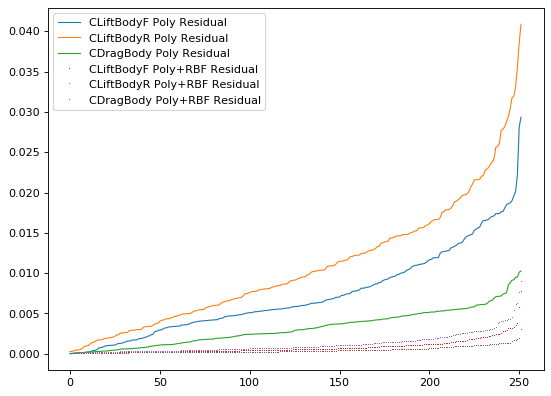

In [58]:
plt.figure(figsize=(8, 6), dpi=80)
for r, output_name in zip(fit_result.polynomial_residuals.T, output_names):
    plt.plot(sorted(abs(r)), '-', lw=1, label=f'{output_name} Poly Residual')
for r, output_name in zip(fit_result.polynomial_rbf_residuals.T, output_names):
    plt.plot(sorted(abs(r)), ',', lw=1, label=f'{output_name} Poly+RBF Residual')
plt.legend()
plt.show()

## Create the car component

In [59]:
aero_component = get_fit_as_component(
    fit_result,
    input_names,
    output_names)

print(json.dumps(aero_component, cls=NumpyEncoder, indent=2))

{
  "PolynomialCLiftBodyFDefinition": [
    {
      "expression": "hRideF * hRideF * hRideF",
      "coefficient": 3319.3183779338992
    },
    {
      "expression": "hRideR * hRideR * hRideR",
      "coefficient": -22.99828253623338
    },
    {
      "expression": "aRollAbs * aRollAbs * aRollAbs",
      "coefficient": 102242.08054790125
    },
    {
      "expression": "hRideF * hRideF",
      "coefficient": 133.67416673512594
    },
    {
      "expression": "hRideR * hRideR",
      "coefficient": -0.8005164043273815
    },
    {
      "expression": "aRollAbs * aRollAbs",
      "coefficient": -1893.7483559197335
    },
    {
      "expression": "hRideF * hRideR",
      "coefficient": -2.0291633812091634
    },
    {
      "expression": "hRideF * aRollAbs",
      "coefficient": -98.92374892277655
    },
    {
      "expression": "hRideR * aRollAbs",
      "coefficient": 4.20244733662337
    },
    {
      "expression": "hRideF",
      "coefficient": -10.058863853385164
    },
    {


## Save a new car to the platform

For this example we'll load the `Canopy F1 Car 2019` and merge in the new aero data before saving it as a new car.

In [60]:
async with create_session() as session:
    input_car = await canopy.load_default_config(
        session,
        'car',
        'Canopy F1 Car 2019')

    # Set these to zero as they are accounted for in the aero data we have fitted.
    input_car.data.aero.CDragBodyUserOffset = 0
    input_car.data.aero.CLiftBodyUserOffset = 0

    # Merge in the new aero component.
    input_car.data.aero = {**input_car.data.aero, **aero_component}

    new_config_id = await canopy.create_config(
        session,
        'car',
        'Canopy F1 Car 2019 with Fitted Aero',
        input_car.data)
    
new_config_id

'b8dddc392fc545088405018740adb447'